In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymodels as pm
import pyaccel as pa
%config Completer.use_jedi = False
from IPython.display import display, Math, Markdown
from scipy.signal import hilbert
T_r = 1.657 * 1e-6 # s


# Checking the damping algorithm

In [2]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.vchamber_on = True
bo.cavity_on = True
bo.radiation_on = True

# Get information 
famdata = pm.bo.get_family_data(bo)

# Setting Coupling
KsL = -0.018 * 1e-3
qs_idx = famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

ed_teng, _ = pa.optics.calc_edwards_teng(bo)
C, _ = pa.optics.estimate_coupling_parameters(ed_teng)
print(f'Coupling coefficient: {C}')

Coupling coefficient: 3.0364413401591303e-05


In [3]:
# Creating the bunch
eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
emit1, emit2 = eqparams.emit1, np.abs(eqparams.emit2)
sigmae, sigmal = eqparams.espread0, eqparams.bunlen
#redistributing emittances
emit1, emit2 = 10*emit1, 3*emit1

npart = 5000
bunch = pa.tracking.generate_bunch(n_part=npart, emit1=emit1,
                                                  emit2=emit2,
                                                  optics=ed_teng[0],
                                                  sigmae=sigmae, sigmas=sigmal)
co = pa.tracking.find_orbit6(accelerator=bo, indices=[0])
# offset = np.zeros([6,1])
# offset[0, 0] = 2e-3
# offset[2, 0] = 2e-3
bunch += co # + offset
init_beam_env = np.cov(bunch)

In [4]:
bo2 = bo[:]
qf_idx = np.array(famdata['QF']['index']).flatten()
KL_default = bo2[qf_idx[0]].KL

N = 30000

emitx_list = np.zeros(N)
emity_list = emitx_list.copy()
tune1_list, tune2_list = emitx_list.copy(), emitx_list.copy()

bunch0 = bunch
env0 = init_beam_env
centroids = np.zeros([6, N])
beam_size = np.zeros([6, N])
env0, cum_mat, bdiff, fixed_point = \
    pa.optics.calc_beamenvelope(accelerator=bo2, init_env=env0, indices='closed', full=True)

for i in range(N):
    # Tracking with quantum radiation excitation
    bunch0 = np.dot(cum_mat[-1], bunch0)
    bunch_excit = pa.tracking.generate_bunch(envelope=bdiff[-1], n_part=npart)
    bunch0 += bunch_excit
    centroids[:, i] = np.mean(bunch0, axis=1)
    beam_size[:, i] = np.std(bunch0, axis=1)
    
    # Computing the RMS emittance
#     twi, *_ = pa.optics.calc_twiss(bo2)
#     etax, etapx = twi.etax[0], twi.etapx[0]
#     etay, etapy = twi.etay[0], twi.etapy[0]
#     disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
#     bunch_nodisp = bunch0 - bunch0[4,:]*disp - np.mean(bunch0, axis=1)[:, None]
#     emitx_list[i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2,:])))
#     emity_list[i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4,:])))
    
#     # Computing Tunes
#     eqparams = pa.optics.EqParamsFromBeamEnvelope(bo2)
#     tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
    
    # Printing progress
    if i % 1000 == 0:
        print(f"step {i}", end='\t')
    if i % 5000 == 0:

        print('')

step 0	
step 1000	step 2000	step 3000	step 4000	step 5000	
step 6000	step 7000	step 8000	step 9000	step 10000	
step 11000	step 12000	step 13000	step 14000	step 15000	
step 16000	step 17000	step 18000	step 19000	step 20000	
step 21000	step 22000	step 23000	step 24000	step 25000	
step 26000	step 27000	step 28000	step 29000	

# Beam size analysis


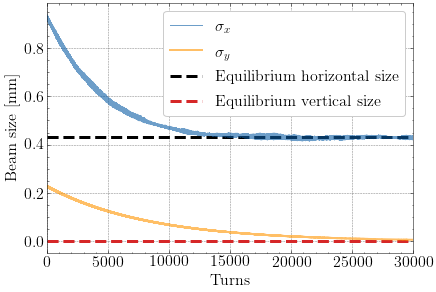

In [35]:
plt.style.use(['science', 'grid'])
sigma_rx = beam_size[0, :]
sigma_ry = beam_size[2, :] 
plt.figure(figsize=[6.5,4.5])
plt.plot(sigma_rx*1e3, label="$\sigma_x$", alpha=0.6, c = 'C0')
plt.plot(sigma_ry*1e3, label="$\sigma_y$", alpha=0.6, lw = 2, c ='C2')
plt.hlines(eqparams.sigma_rx[0]*1e3, 0, N, linestyles='--', 
           label='Equilibrium horizontal size', color='k', linewidth=3)
plt.hlines(eqparams.sigma_ry[0]*1e3, 0, N, linestyles='--',
           color='tab:red', label='Equilibrium vertical size', linewidth=3)
plt.ylabel("Beam size [mm]")
plt.xlabel("Turns")
plt.legend()
# plt.title("Beam dimensions with radiation and quantum excitation on")
plt.xlim([0, N])
plt.savefig("figures/emit_exchange_studies/beam_size.pdf")
plt.tight_layout()
plt.show()


Horizontal damping time: -6.5179365856505616


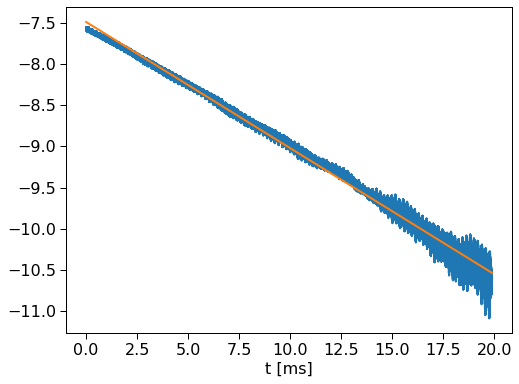

In [112]:
mean = np.mean(sigma_rx[20000:])
logsigmax = np.log(sigma_rx[:12000]-mean)
Ns = np.arange(N)[:12000]
t = Ns*T_r*1e3 # [ms]
coeff = np.polyfit(t, logsigmax, 1)
plt.plot(t, logsigmax)
plt.plot(t, coeff[1] + coeff[0]*t)
plt.xlabel("t [ms]")
print(f"Horizontal damping time: {1/coeff[0]}")

Vertical damping time: -7.911059749187347


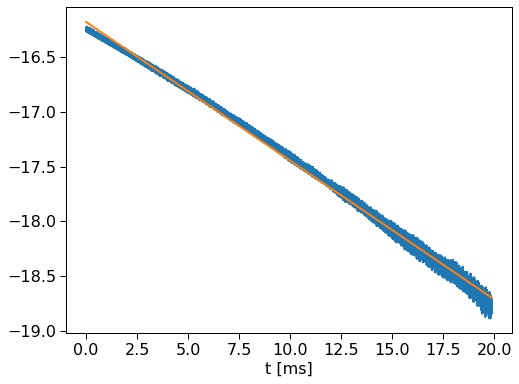

In [27]:
mean = np.mean(sigma_ry[20000:])
logsigmay = np.log(sigma_ry[:12000]-mean)
Ns = np.arange(N)[:12000]
t = Ns*T_r*1e3 # [ms]
coeff = np.polyfit(t, logsigmay, 1)
plt.plot(t, logsigmay)
plt.plot(t, coeff[1] + coeff[0]*t)
plt.xlabel("t [ms]")
print(f"Vertical damping time: {1/coeff[0]}")

# Centroid analysis

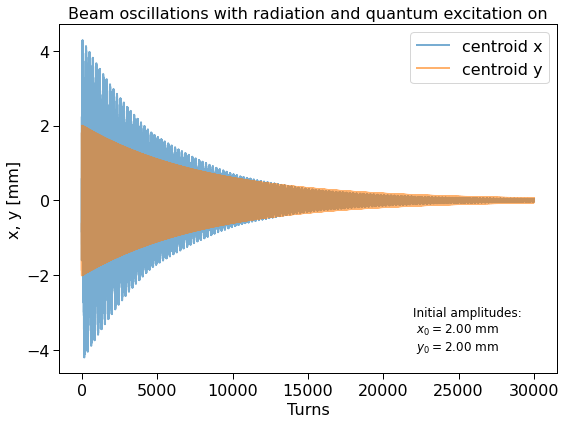

In [19]:
# %matplotlib qt5
%matplotlib inline
plt.style.use(['notebook', 'no-latex'])
rx = centroids[0, :]
ry = centroids[2, :] 

plt.plot(rx*1e3, label="centroid x", alpha=0.6)
plt.plot(ry*1e3, label="centroid y", alpha=0.6)

plt.ylabel("x, y [mm]")
plt.xlabel("Turns")
plt.text(x=22000,y=-4,
         s='Initial amplitudes: \n $x_0 = '
         '{:.2f}$ mm \n $y_0 = {:.2f}$ mm'.format(offset[0,0]*1e3, offset[2,0]*1e3), fontsize=12)
plt.legend()
plt.title("Beam oscillations with radiation and quantum excitation on")
plt.tight_layout()
plt.savefig('figures/centroid_damping.png', dpi=160, transparent=False, facecolor='white')
plt.show()

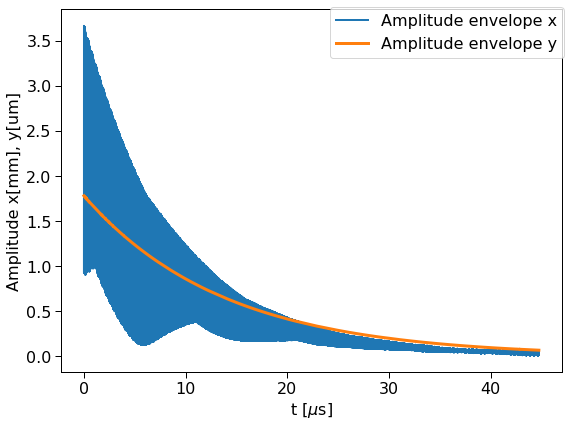

In [21]:
analytic_signalx = hilbert(rx)
analytic_signaly = hilbert(ry)
amplitude_envelopex = np.abs(analytic_signalx)[1000:-2000]
amplitude_envelopey = np.abs(analytic_signaly)[1000:-2000]
tx = np.arange(amplitude_envelopex.size) * T_r * 1e3 # ms
ty = np.arange(amplitude_envelopey.size) * T_r * 1e3 # ms

fig, ax = plt.subplots(1,1, sharex=True)
ax.plot(tx, amplitude_envelopex*1e3,  label="Amplitude envelope x")
ax.plot(ty, amplitude_envelopey*1e3,  label="Amplitude envelope y", linewidth=3)
ax.set_ylabel("Amplitude x[mm], y[um]")
ax.set_xlabel("t [$\mu$s]")

fig.legend()
plt.tight_layout()
plt.savefig('figures/amplitude_damping.png', dpi=160, transparent=False, facecolor='white')
plt.show()

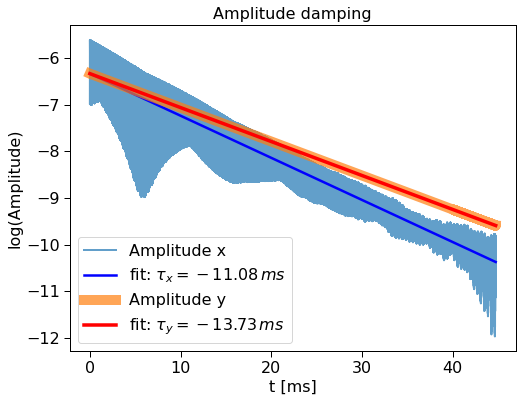

In [25]:
log_ampx = np.log(amplitude_envelopex)
coeffx = np.polynomial.polynomial.polyfit(tx, log_ampx, 1)

log_ampy = np.log(amplitude_envelopey)
coeffy = np.polynomial.polynomial.polyfit(ty, log_ampy, 1)

plt.plot(tx, log_ampx,  alpha=0.7, label='Amplitude x')
plt.plot(tx, coeffx[0] + coeffx[1]*tx, linewidth = 2.5, c='blue', 
         label=r'fit: $\tau_x = {:.2f} \, ms$'.format(1/coeffx[1]))

plt.plot(ty, log_ampy,  alpha=0.7,c='tab:orange', label='Amplitude y', linewidth=10)
plt.plot(ty, coeffy[0] + coeffy[1]*ty, linewidth = 3.5, c='red', 
         label=r'fit: $\tau_y = {:.2f} \, ms$'.format(1/coeffy[1]))

plt.title("Amplitude damping")
plt.ylabel('log(Amplitude)')
plt.xlabel("t [ms]")
plt.legend(loc='lower left')
plt.savefig('figures/logamplitude_damping.png', dpi=160, facecolor='white')
plt.show()

In [158]:
coeffy, coeffx

(array([-15.47931117,  -0.09130543]), array([-6.22547984, -0.08956982]))